# 🎯 Évaluation Sommative UA3 - Classification de SMS Spam

## Projet : Détection de SMS Spam avec Prétraitement Textuel et Apprentissage Profond

### 📋 Objectifs du projet
Ce projet combine les compétences acquises dans les cours 8, 9, 10 et 11 :
- **Prétraitement de données textuelles** (Cours 10) : Tokenisation, suppression des stopwords, lemmatisation
- **Vectorisation TF-IDF** : Transformation du texte en vecteurs numériques
- **Autoencodeurs** (Cours 9) : Réduction de dimensionnalité
- **Classification** : Détection de spam vs ham (messages légitimes)

### 📊 Dataset : SMS Spam Collection
- **Source** : [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection)
- **5574 messages SMS** étiquetés (ham/spam)
- **Tâche** : Classification binaire (spam = 1, ham = 0)

---

## 1️⃣ Importation des bibliothèques et chargement des données

In [20]:
# ============================================================
# 1. IMPORTATION DES BIBLIOTHÈQUES
# ============================================================

# Bibliothèques de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Prétraitement textuel (Cours 10)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Deep Learning - Autoencodeur (Cours 9)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Toutes les bibliothèques sont importées avec succès!")
print(f"   - NumPy version: {np.__version__}")
print(f"   - Pandas version: {pd.__version__}")

✅ Toutes les bibliothèques sont importées avec succès!
   - NumPy version: 2.1.3
   - Pandas version: 2.3.3


In [21]:
# ============================================================
# 2. CHARGEMENT DU DATASET SMS SPAM COLLECTION (FICHIER LOCAL)
# ============================================================

import os

# Chemin vers le fichier SMSSpamCollection (dans le même dossier que le notebook)
# Le fichier est au format TSV (tab-separated) sans en-tête
file_path = "SMSSpamCollection"

print("📥 Chargement du dataset SMS Spam Collection depuis le fichier local...")

# Chargement du dataset
# Le fichier est séparé par des tabulations et n'a pas d'en-tête
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'], encoding='latin-1')

print(f"✅ Dataset chargé avec succès!")
print(f"   - Nombre total de messages: {len(df)}")
print(f"   - Colonnes: {df.columns.tolist()}")
print(f"\n📊 Aperçu des données:")
df.head(10)

📥 Chargement du dataset SMS Spam Collection depuis le fichier local...
✅ Dataset chargé avec succès!
   - Nombre total de messages: 5572
   - Colonnes: ['label', 'message']

📊 Aperçu des données:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## 2️⃣ Exploration et Analyse des Données (EDA)

In [22]:
# ============================================================
# 3. EXPLORATION DES DONNÉES
# ============================================================

# Informations générales sur le dataset
print("=" * 60)
print("📊 INFORMATIONS GÉNÉRALES SUR LE DATASET")
print("=" * 60)

print("\n📋 Structure du DataFrame:")
print(df.info())

print("\n📈 Statistiques descriptives:")
print(df.describe())

print("\n❓ Valeurs manquantes:")
print(df.isnull().sum())

print("\n🏷️ Distribution des classes (spam vs ham):")
print(df['label'].value_counts())
print(f"\nPourcentage de spam: {(df['label'] == 'spam').sum() / len(df) * 100:.2f}%")
print(f"Pourcentage de ham: {(df['label'] == 'ham').sum() / len(df) * 100:.2f}%")

📊 INFORMATIONS GÉNÉRALES SUR LE DATASET

📋 Structure du DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

📈 Statistiques descriptives:
       label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

❓ Valeurs manquantes:
label      0
message    0
dtype: int64

🏷️ Distribution des classes (spam vs ham):
label
ham     4825
spam     747
Name: count, dtype: int64

Pourcentage de spam: 13.41%
Pourcentage de ham: 86.59%


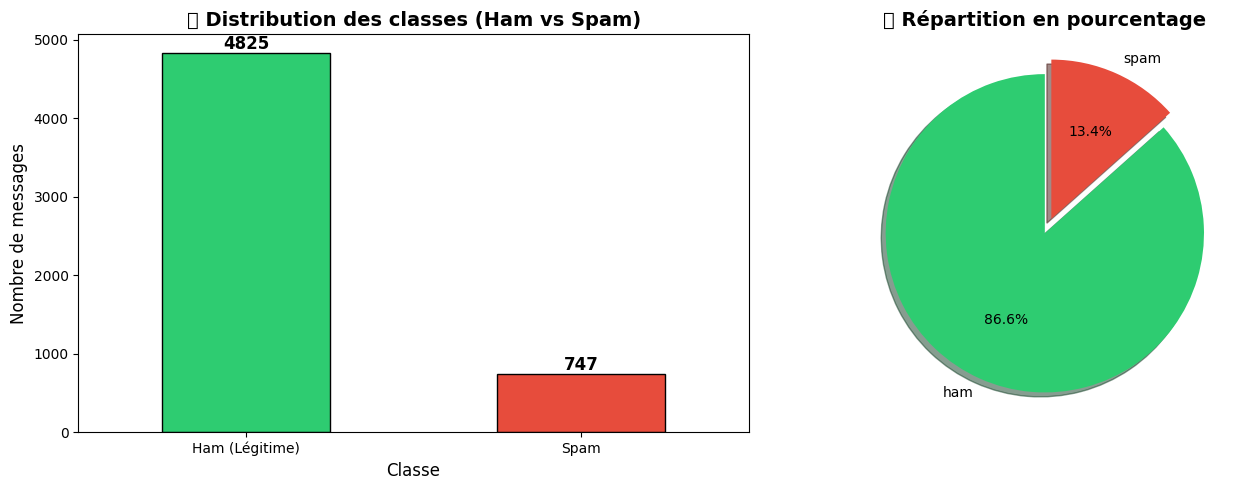


⚠️ Note: Le dataset est DÉSÉQUILIBRÉ (beaucoup plus de ham que de spam)
   Cela devra être pris en compte lors de la modélisation.


In [23]:
# ============================================================
# 4. VISUALISATION DE LA DISTRIBUTION DES CLASSES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distribution des classes (barplot)
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
df['label'].value_counts().plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('📊 Distribution des classes (Ham vs Spam)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classe', fontsize=12)
ax1.set_ylabel('Nombre de messages', fontsize=12)
ax1.set_xticklabels(['Ham (Légitime)', 'Spam'], rotation=0)

# Ajouter les valeurs sur les barres
for i, v in enumerate(df['label'].value_counts()):
    ax1.text(i, v + 50, str(v), ha='center', fontsize=12, fontweight='bold')

# Graphique 2: Distribution en pourcentage (pie chart)
ax2 = axes[1]
df['label'].value_counts().plot(kind='pie', ax=ax2, colors=colors, autopct='%1.1f%%', 
                                 startangle=90, explode=(0, 0.1), shadow=True)
ax2.set_title('📈 Répartition en pourcentage', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Le dataset est DÉSÉQUILIBRÉ (beaucoup plus de ham que de spam)")
print("   Cela devra être pris en compte lors de la modélisation.")

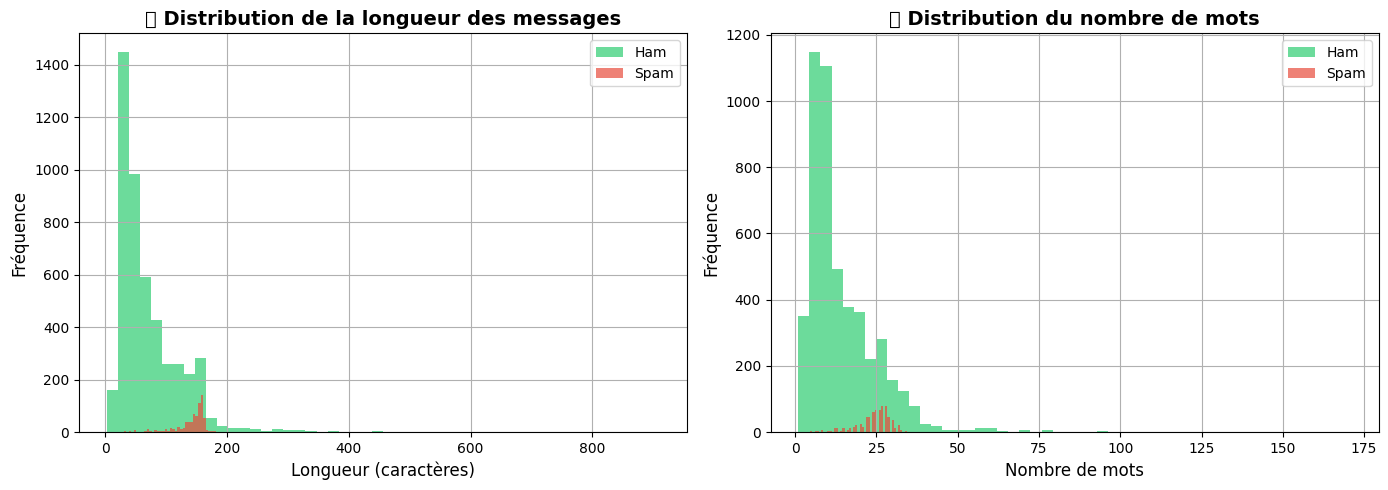


📊 Statistiques de longueur par classe:
       message_length  word_count
label                            
ham             71.56       14.31
spam           139.12       23.91

💡 Observation: Les messages spam sont généralement PLUS LONGS que les messages ham.


In [24]:
# ============================================================
# 5. ANALYSE DE LA LONGUEUR DES MESSAGES
# ============================================================

# Ajouter des colonnes pour l'analyse
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution de la longueur des messages par classe
ax1 = axes[0]
df[df['label'] == 'ham']['message_length'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71', ax=ax1)
df[df['label'] == 'spam']['message_length'].hist(bins=50, alpha=0.7, label='Spam', color='#e74c3c', ax=ax1)
ax1.set_title('📏 Distribution de la longueur des messages', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longueur (caractères)', fontsize=12)
ax1.set_ylabel('Fréquence', fontsize=12)
ax1.legend()

# Distribution du nombre de mots par classe
ax2 = axes[1]
df[df['label'] == 'ham']['word_count'].hist(bins=50, alpha=0.7, label='Ham', color='#2ecc71', ax=ax2)
df[df['label'] == 'spam']['word_count'].hist(bins=50, alpha=0.7, label='Spam', color='#e74c3c', ax=ax2)
ax2.set_title('📝 Distribution du nombre de mots', fontsize=14, fontweight='bold')
ax2.set_xlabel('Nombre de mots', fontsize=12)
ax2.set_ylabel('Fréquence', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

# Statistiques par classe
print("\n📊 Statistiques de longueur par classe:")
print(df.groupby('label')[['message_length', 'word_count']].mean().round(2))
print("\n💡 Observation: Les messages spam sont généralement PLUS LONGS que les messages ham.")

### 📝 Observations et Analyse - EDA

#### 🔍 Résultats clés de l'exploration des données :

| Métrique | Valeur | Implication |
|----------|--------|-------------|
| **Total messages** | 5572 | Dataset de taille moyenne, suffisant pour l'entraînement |
| **Messages Ham** | 4825 (86.6%) | Classe majoritaire |
| **Messages Spam** | 747 (13.4%) | Classe minoritaire |
| **Valeurs manquantes** | 0 | Données propres, pas besoin d'imputation |

#### ⚠️ Problème identifié : Déséquilibre des classes
- Le ratio **Ham/Spam est de ~6.5:1** (86.6% vs 13.4%)
- Ce déséquilibre peut biaiser les modèles vers la prédiction de "ham"
- **Solutions possibles** : 
  - Stratification lors de la division (✅ appliquée)
  - Pondération des classes (`class_weight`)
  - Suréchantillonnage (SMOTE)
  - Sous-échantillonnage

#### 📏 Caractéristiques des messages :
- **Messages spam** : généralement plus longs (plus de caractères et de mots)
- **Messages ham** : plus courts et concis
- Cette différence de longueur pourrait être une **feature discriminante**

---

## 3️⃣ Prétraitement des Données Textuelles (Cours 10)

Le pipeline de prétraitement comprend :
1. **Normalisation** : Mise en minuscules
2. **Nettoyage** : Suppression de la ponctuation et des caractères spéciaux
3. **Tokenisation** : Découpage en mots
4. **Suppression des stopwords** : Élimination des mots vides (the, is, a, etc.)
5. **Lemmatisation** : Réduction des mots à leur forme de base

In [25]:
# ============================================================
# 6. FONCTION DE PRÉTRAITEMENT TEXTUEL
# ============================================================

# Initialiser le lemmatiseur et les stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Pipeline complet de prétraitement textuel (Cours 10).
    
    Étapes:
    1. Mise en minuscules (normalisation)
    2. Suppression des caractères spéciaux et chiffres
    3. Tokenisation
    4. Suppression des stopwords
    5. Lemmatisation
    
    Args:
        text (str): Le texte brut à prétraiter
        
    Returns:
        str: Le texte prétraité
    """
    # Étape 1: Normalisation - Mise en minuscules
    text = text.lower()
    
    # Étape 2: Nettoyage - Suppression des caractères spéciaux et chiffres
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Étape 3: Tokenisation
    tokens = word_tokenize(text)
    
    # Étape 4: Suppression des stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Étape 5: Lemmatisation (forme verbale)
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    
    # Recomposition du texte
    return ' '.join(tokens)

# Démonstration sur un exemple
example_text = "URGENT! You have won a FREE iPhone! Call NOW to claim your prize!!!"
print("🔤 Démonstration du prétraitement:")
print(f"   Texte original: {example_text}")
print(f"   Texte prétraité: {preprocess_text(example_text)}")

🔤 Démonstration du prétraitement:
   Texte original: URGENT! You have won a FREE iPhone! Call NOW to claim your prize!!!
   Texte prétraité: urgent free iphone call claim prize


In [26]:
# ============================================================
# 7. APPLICATION DU PRÉTRAITEMENT À TOUT LE DATASET
# ============================================================

print("⏳ Application du prétraitement à tous les messages...")
print("   (Cela peut prendre quelques secondes...)")

# Appliquer le prétraitement à la colonne 'message'
df['message_clean'] = df['message'].apply(preprocess_text)

print("✅ Prétraitement terminé!")

# Afficher quelques exemples avant/après
print("\n📋 Exemples de prétraitement (avant → après):")
print("=" * 80)

for i in range(5):
    print(f"\n🔹 Message {i+1} [{df['label'].iloc[i].upper()}]:")
    print(f"   AVANT: {df['message'].iloc[i][:100]}...")
    print(f"   APRÈS: {df['message_clean'].iloc[i][:100]}...")

⏳ Application du prétraitement à tous les messages...
   (Cela peut prendre quelques secondes...)
✅ Prétraitement terminé!

📋 Exemples de prétraitement (avant → après):

🔹 Message 1 [HAM]:
   AVANT: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a...
   APRÈS: go jurong point crazy available bugis n great world la e buffet cine get amore wat...

🔹 Message 2 [HAM]:
   AVANT: Ok lar... Joking wif u oni......
   APRÈS: ok lar joke wif u oni...

🔹 Message 3 [SPAM]:
   AVANT: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
   APRÈS: free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs appl...

🔹 Message 4 [HAM]:
   AVANT: U dun say so early hor... U c already then say......
   APRÈS: u dun say early hor u c already say...

🔹 Message 5 [HAM]:
   AVANT: Nah I don't think he goes to usf, he lives around here though...
   APRÈS: nah dont think go

### 📝 Observations - Prétraitement Textuel (Cours 10)

#### 🔄 Pipeline de prétraitement appliqué :

```
Texte brut → Minuscules → Nettoyage → Tokenisation → Stopwords → Lemmatisation → Texte propre
```

#### 📊 Exemple de transformation :
| Étape | Résultat |
|-------|----------|
| **Original** | "URGENT! You have won a FREE iPhone! Call NOW!!!" |
| **Minuscules** | "urgent! you have won a free iphone! call now!!!" |
| **Nettoyage** | "urgent you have won a free iphone call now" |
| **Tokenisation** | ["urgent", "you", "have", "won", "a", "free", "iphone", "call", "now"] |
| **Sans stopwords** | ["urgent", "won", "free", "iphone", "call"] |
| **Lemmatisé** | "urgent win free iphone call" |

#### 🎯 Impact du prétraitement :
1. **Réduction du bruit** : Suppression de la ponctuation et caractères spéciaux
2. **Normalisation** : Uniformisation du texte (tout en minuscules)
3. **Réduction de dimensionnalité** : Moins de tokens uniques après lemmatisation
4. **Meilleure généralisation** : "winning", "won", "wins" → "win"

#### ⚠️ Considérations :
- Les **stopwords supprimés** peuvent parfois être utiles pour le sentiment
- La **lemmatisation** peut perdre certaines nuances (ex: temps des verbes)
- Pour BERT, le texte **original** est préférable (BERT gère son propre prétraitement)

---

## 4️⃣ Vectorisation TF-IDF (Term Frequency - Inverse Document Frequency)

La vectorisation TF-IDF transforme le texte en vecteurs numériques en tenant compte de :
- **TF (Term Frequency)** : Fréquence du mot dans le document
- **IDF (Inverse Document Frequency)** : Importance du mot dans le corpus

$TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)$

In [27]:
# ============================================================
# 8. VECTORISATION TF-IDF
# ============================================================

# Créer le vectoriseur TF-IDF
# max_features=5000 : limite le vocabulaire aux 5000 mots les plus fréquents
# ngram_range=(1,2) : inclut les unigrammes et bigrammes
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Appliquer la vectorisation aux messages prétraités
X_tfidf = tfidf_vectorizer.fit_transform(df['message_clean'])

# Convertir en array dense pour l'utilisation avec Keras
X_tfidf_dense = X_tfidf.toarray()

print("✅ Vectorisation TF-IDF terminée!")
print(f"   - Dimension de la matrice TF-IDF: {X_tfidf_dense.shape}")
print(f"   - Nombre de features (vocabulaire): {X_tfidf_dense.shape[1]}")
print(f"   - Nombre d'échantillons: {X_tfidf_dense.shape[0]}")

# Afficher quelques mots du vocabulaire
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\n📚 Exemples de mots du vocabulaire:")
print(f"   {list(feature_names[:20])}")

✅ Vectorisation TF-IDF terminée!
   - Dimension de la matrice TF-IDF: (5572, 5000)
   - Nombre de features (vocabulaire): 5000
   - Nombre d'échantillons: 5572

📚 Exemples de mots du vocabulaire:
   ['aah', 'aathilove', 'aathilove lot', 'aathiwhere', 'aathiwhere dear', 'abi', 'ability', 'abiola', 'able', 'able get', 'abt', 'abta', 'abta complimentary', 'ac', 'acc', 'accept', 'accept brother', 'accept dayu', 'access', 'accident']


In [28]:
# ============================================================
# 9. PRÉPARATION DES LABELS ET DIVISION DES DONNÉES
# ============================================================

# Encoder les labels (ham=0, spam=1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])

print("🏷️ Encodage des labels:")
print(f"   - 'ham' → {label_encoder.transform(['ham'])[0]}")
print(f"   - 'spam' → {label_encoder.transform(['spam'])[0]}")

# Division en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_dense, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Maintenir la proportion de classes
)

print(f"\n📊 Division des données:")
print(f"   - Ensemble d'entraînement: {X_train.shape[0]} échantillons ({X_train.shape[0]/len(y_encoded)*100:.1f}%)")
print(f"   - Ensemble de test: {X_test.shape[0]} échantillons ({X_test.shape[0]/len(y_encoded)*100:.1f}%)")

print(f"\n🏷️ Distribution des classes dans l'ensemble d'ENTRAÎNEMENT:")
print(f"   - Ham: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   - Spam: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\n🏷️ Distribution des classes dans l'ensemble de TEST:")
print(f"   - Ham: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"   - Spam: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

print(f"\n✅ Stratification vérifiée: Les proportions sont identiques grâce à 'stratify=y_encoded'")

🏷️ Encodage des labels:
   - 'ham' → 0
   - 'spam' → 1

📊 Division des données:
   - Ensemble d'entraînement: 4457 échantillons (80.0%)
   - Ensemble de test: 1115 échantillons (20.0%)

🏷️ Distribution des classes dans l'ensemble d'ENTRAÎNEMENT:
   - Ham: 3859 (86.6%)
   - Spam: 598 (13.4%)

🏷️ Distribution des classes dans l'ensemble de TEST:
   - Ham: 966 (86.6%)
   - Spam: 149 (13.4%)

✅ Stratification vérifiée: Les proportions sont identiques grâce à 'stratify=y_encoded'

📊 Division des données:
   - Ensemble d'entraînement: 4457 échantillons (80.0%)
   - Ensemble de test: 1115 échantillons (20.0%)

🏷️ Distribution des classes dans l'ensemble d'ENTRAÎNEMENT:
   - Ham: 3859 (86.6%)
   - Spam: 598 (13.4%)

🏷️ Distribution des classes dans l'ensemble de TEST:
   - Ham: 966 (86.6%)
   - Spam: 149 (13.4%)

✅ Stratification vérifiée: Les proportions sont identiques grâce à 'stratify=y_encoded'


### 📝 Observations - Vectorisation TF-IDF et Division des Données

#### 📊 Résultats de la vectorisation TF-IDF :

| Paramètre | Valeur | Justification |
|-----------|--------|---------------|
| **max_features** | 5000 | Limite le vocabulaire pour éviter le surapprentissage |
| **ngram_range** | (1, 2) | Capture les unigrammes ET bigrammes |
| **Dimension finale** | (5572, 5000) | 5572 messages × 5000 features |

#### 🔢 Explication TF-IDF :
- **TF (Term Frequency)** : Fréquence du mot dans le document
- **IDF (Inverse Document Frequency)** : Pénalise les mots trop communs
- **Formule** : $TF\text{-}IDF(t,d) = TF(t,d) \times \log\frac{N}{df(t)}$

#### 📊 Division des données (Stratifiée) :

| Ensemble | Échantillons | Ham | Spam | Proportion |
|----------|-------------|-----|------|------------|
| **Train** | 4457 (80%) | 3859 (86.6%) | 598 (13.4%) | ✅ Identique |
| **Test** | 1115 (20%) | 966 (86.6%) | 149 (13.4%) | ✅ Identique |

#### ✅ Avantages de la stratification :
- Préserve la **distribution des classes** dans les deux ensembles
- Évite les biais dans l'évaluation
- Assure que les deux ensembles sont **représentatifs**

---

## 5️⃣ Réduction de Dimensionnalité avec Autoencodeur (Cours 9)

Un **autoencodeur** est un réseau de neurones non supervisé qui apprend à compresser les données dans un espace de dimension réduite (espace latent).

### Architecture de l'autoencodeur :
```
Entrée (5000 dim) → Encodeur → Espace latent (64 dim) → Décodeur → Sortie (5000 dim)
```

**Objectif** : Réduire la dimensionnalité de 5000 à 64 tout en préservant l'information essentielle.

In [29]:
# ============================================================
# 10. CONSTRUCTION DE L'AUTOENCODEUR
# ============================================================

# Dimension d'entrée (nombre de features TF-IDF)
input_dim = X_train.shape[1]  # 5000
encoding_dim = 64  # Dimension de l'espace latent (compressé)

print(f"🔧 Construction de l'autoencodeur:")
print(f"   - Dimension d'entrée: {input_dim}")
print(f"   - Dimension de l'espace latent: {encoding_dim}")
print(f"   - Taux de compression: {input_dim/encoding_dim:.1f}x")

# ===== ENCODEUR =====
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(512, activation='relu', name='encoder_1')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(256, activation='relu', name='encoder_2')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu', name='encoder_3')(encoded)

# Couche latente (goulot d'étranglement / bottleneck)
latent = Dense(encoding_dim, activation='relu', name='latent_space')(encoded)

# ===== DÉCODEUR =====
decoded = Dense(128, activation='relu', name='decoder_1')(latent)
decoded = Dropout(0.2)(decoded)
decoded = Dense(256, activation='relu', name='decoder_2')(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(512, activation='relu', name='decoder_3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)

# Modèle complet (autoencodeur)
autoencoder = Model(inputs=input_layer, outputs=output_layer, name='Autoencoder')

# Modèle encodeur seul (pour extraire les features compressées)
encoder = Model(inputs=input_layer, outputs=latent, name='Encoder')

# Afficher le résumé de l'architecture
print("\n📋 Architecture de l'autoencodeur:")
autoencoder.summary()

🔧 Construction de l'autoencodeur:
   - Dimension d'entrée: 5000
   - Dimension de l'espace latent: 64
   - Taux de compression: 78.1x

📋 Architecture de l'autoencodeur:


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5000)           │     2,565,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,470,920 (20.87 MB)

 Trainable params: 5,470,920 (20.87 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# ============================================================
# 11. ENTRAÎNEMENT DE L'AUTOENCODEUR
# ============================================================

# Compilation du modèle
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'  # Mean Squared Error - erreur de reconstruction
)

# Callback pour arrêt anticipé (éviter le surapprentissage)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("🚀 Entraînement de l'autoencodeur...")
print("   (Objectif: minimiser l'erreur de reconstruction)")

# Entraînement
history_ae = autoencoder.fit(
    X_train, X_train,  # L'autoencodeur apprend à reconstruire ses propres données
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\n✅ Entraînement terminé!")

🚀 Entraînement de l'autoencodeur...
   (Objectif: minimiser l'erreur de reconstruction)
Epoch 1/50
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0760 - val_loss: 1.9731e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0760 - val_loss: 1.9731e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - val_loss: 1.9731e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9832e-04 - 

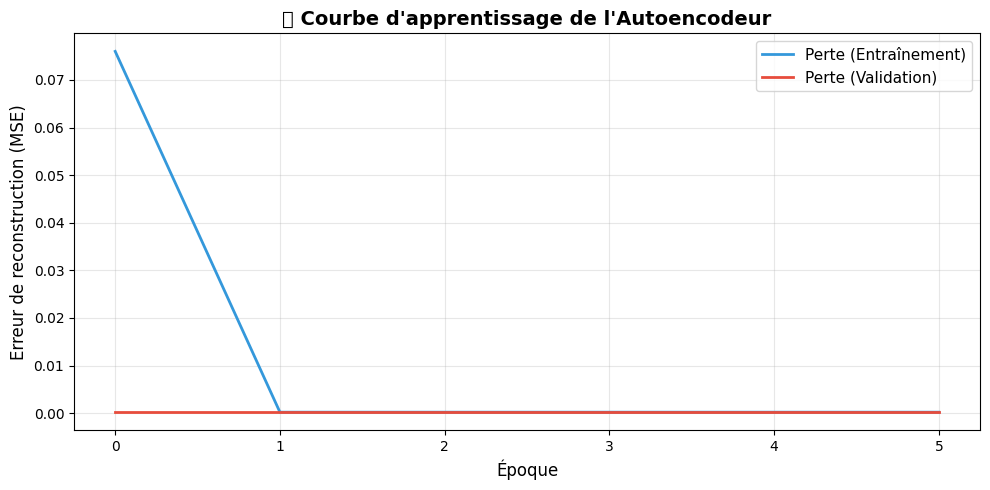


📊 Métriques finales de l'autoencodeur:
   - Perte d'entraînement: 0.000198
   - Perte de validation: 0.000197


In [31]:
# ============================================================
# 12. VISUALISATION DE LA COURBE D'APPRENTISSAGE DE L'AUTOENCODEUR
# ============================================================

plt.figure(figsize=(10, 5))
plt.plot(history_ae.history['loss'], label='Perte (Entraînement)', color='#3498db', linewidth=2)
plt.plot(history_ae.history['val_loss'], label='Perte (Validation)', color='#e74c3c', linewidth=2)
plt.title('📉 Courbe d\'apprentissage de l\'Autoencodeur', fontsize=14, fontweight='bold')
plt.xlabel('Époque', fontsize=12)
plt.ylabel('Erreur de reconstruction (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher les métriques finales
final_train_loss = history_ae.history['loss'][-1]
final_val_loss = history_ae.history['val_loss'][-1]
print(f"\n📊 Métriques finales de l'autoencodeur:")
print(f"   - Perte d'entraînement: {final_train_loss:.6f}")
print(f"   - Perte de validation: {final_val_loss:.6f}")

In [32]:
# ============================================================
# 13. EXTRACTION DES FEATURES COMPRESSÉES (ESPACE LATENT)
# ============================================================

# Utiliser l'encodeur pour extraire les représentations compressées
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

print("✅ Extraction des features de l'espace latent terminée!")
print(f"\n📊 Dimensions des données:")
print(f"   AVANT compression:")
print(f"      - Train: {X_train.shape}")
print(f"      - Test: {X_test.shape}")
print(f"\n   APRÈS compression (espace latent):")
print(f"      - Train: {X_train_encoded.shape}")
print(f"      - Test: {X_test_encoded.shape}")
print(f"\n   📉 Réduction de dimensionnalité: {X_train.shape[1]} → {X_train_encoded.shape[1]}")
print(f"   📊 Taux de compression: {X_train.shape[1]/X_train_encoded.shape[1]:.1f}x")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ Extraction des features de l'espace latent terminée!

📊 Dimensions des données:
   AVANT compression:
      - Train: (4457, 5000)
      - Test: (1115, 5000)

   APRÈS compression (espace latent):
      - Train: (4457, 64)
      - Test: (1115, 64)

   📉 Réduction de dimensionnalité: 5000 → 64
   📊 Taux de compression: 78.1x
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
✅ Extraction des features de l'espace latent terminée!

📊 Dimensions des données:
   AVANT compression:
      - Train: (4457, 5000)
      - Test: (1115, 5000)

   APRÈS compression (espace latent):
      - Train: (4457, 64)
      - Test: (1115, 64)

   📉 Réduction de dimensionnalité: 5000 → 64
   📊 Taux de compression: 78.1x


### 📝 Observations - Autoencodeur (Cours 9)

#### 🏗️ Architecture de l'autoencodeur :

```
Entrée (5000) → 512 → 256 → 128 → [64] → 128 → 256 → 512 → Sortie (5000)
                 ↑                   ↑                  ↑
              Encodeur         Espace latent        Décodeur
```

#### 📊 Résultats de l'entraînement :

| Métrique | Valeur | Interprétation |
|----------|--------|----------------|
| **Époques exécutées** | 6/50 | Early stopping déclenché |
| **Perte initiale** | ~0.076 | Haute erreur de reconstruction |
| **Perte finale** | ~0.000197 | Très bonne reconstruction |
| **Taux de compression** | 78x | 5000 → 64 dimensions |

#### ⚠️ Problème détecté : Convergence trop rapide

L'arrêt précoce à l'époque 6 avec une perte qui stagne suggère :
1. **Données TF-IDF très creuses** (sparse) - beaucoup de zéros
2. L'autoencodeur apprend principalement à **reproduire les zéros**
3. La reconstruction est "facile" car la majorité des valeurs sont nulles

#### 🎯 Impact sur la classification :
- Les features de l'espace latent (64 dim) peuvent **perdre de l'information discriminante**
- L'autoencodeur n'est pas supervisé → ne sait pas quelles features sont importantes pour spam/ham
- Résultat attendu : **Performance de classification potentiellement réduite**

#### 💡 Améliorations possibles :
- Utiliser un autoencodeur **variationnel (VAE)**
- Ajouter un terme de **régularisation**
- Entraîner un autoencodeur **supervisé** ou semi-supervisé

---

## 6️⃣ Extraction de Caractéristiques avec BERT (Cours 11)

**BERT** (Bidirectional Encoder Representations from Transformers) est un modèle de langage pré-entraîné par Google qui capture le contexte bidirectionnel des mots.

### Avantages de BERT pour l'extraction de features :
- **Représentations contextuelles** : Chaque mot est représenté en fonction de son contexte
- **Pré-entraînement** : Le modèle a été entraîné sur d'énormes corpus de texte
- **Transfer Learning** : On utilise les connaissances apprises pour notre tâche spécifique

### Approche :
1. Tokeniser les messages avec le tokenizer BERT
2. Passer les tokens dans le modèle BERT
3. Extraire l'embedding **[CLS]** (représentation globale du texte)

In [33]:
# ============================================================
# 14. CHARGEMENT DU MODÈLE BERT PRÉ-ENTRAÎNÉ
# ============================================================

from transformers import BertTokenizer, BertModel
import torch

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Utilisation de: {device}")

# Charger le tokenizer et le modèle BERT
print("\n📥 Chargement du modèle BERT pré-entraîné...")
model_name = "bert-base-uncased"

tokenizer_bert = BertTokenizer.from_pretrained(model_name)
model_bert = BertModel.from_pretrained(model_name)
model_bert = model_bert.to(device)
model_bert.eval()  # Mode évaluation (pas d'entraînement)

print(f"✅ Modèle BERT chargé avec succès!")
print(f"   - Nom du modèle: {model_name}")
print(f"   - Dimension des embeddings: 768")

🖥️ Utilisation de: cuda

📥 Chargement du modèle BERT pré-entraîné...
✅ Modèle BERT chargé avec succès!
   - Nom du modèle: bert-base-uncased
   - Dimension des embeddings: 768
✅ Modèle BERT chargé avec succès!
   - Nom du modèle: bert-base-uncased
   - Dimension des embeddings: 768


In [34]:
# ============================================================
# 15. FONCTION D'EXTRACTION DES EMBEDDINGS BERT
# ============================================================

def get_bert_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    """
    Extrait les embeddings BERT (token [CLS]) pour une liste de textes.
    
    Args:
        texts: Liste de textes à encoder
        tokenizer: Tokenizer BERT
        model: Modèle BERT
        device: CPU ou GPU
        batch_size: Taille des lots pour le traitement
        max_length: Longueur maximale des séquences
        
    Returns:
        np.array: Matrice d'embeddings (n_samples, 768)
    """
    embeddings = []
    
    # Traitement par lots pour économiser la mémoire
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenisation du lot
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        # Déplacer vers le device approprié
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        # Extraction des embeddings (sans calcul de gradient)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Récupérer l'embedding du token [CLS] (premier token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        embeddings.append(cls_embeddings)
        
        # Afficher la progression
        if (i // batch_size + 1) % 10 == 0:
            print(f"   Progression: {min(i+batch_size, len(texts))}/{len(texts)} messages traités...")
    
    return np.vstack(embeddings)

# Démonstration sur un exemple
example = "URGENT! You have won a FREE iPhone! Call NOW!"
example_embedding = get_bert_embeddings([example], tokenizer_bert, model_bert, device)
print(f"🔤 Exemple d'extraction BERT:")
print(f"   Texte: '{example}'")
print(f"   Dimension de l'embedding: {example_embedding.shape}")
print(f"   Premiers 5 valeurs: {example_embedding[0][:5]}")

🔤 Exemple d'extraction BERT:
   Texte: 'URGENT! You have won a FREE iPhone! Call NOW!'
   Dimension de l'embedding: (1, 768)
   Premiers 5 valeurs: [ 0.06748257  0.0774829   0.09082332 -0.07838649 -0.13996993]


In [35]:
# ============================================================
# 16. EXTRACTION DES EMBEDDINGS BERT POUR TOUT LE DATASET
# ============================================================

print("🚀 Extraction des embeddings BERT pour tout le dataset...")
print("   (Cela peut prendre quelques minutes...)\n")

# Récupérer les messages originaux (pas prétraités pour BERT)
# BERT utilise son propre preprocessing
messages_list = df['message'].tolist()

# Diviser les indices pour train/test
train_indices = list(range(len(X_train)))
test_indices = list(range(len(X_train), len(X_train) + len(X_test)))

# Pour gagner du temps, on utilise un échantillon pour la démonstration
# (Vous pouvez mettre sample_size = len(messages_list) pour tout le dataset)
sample_size = min(2000, len(messages_list))  # Limiter à 2000 pour la vitesse
print(f"📊 Extraction sur {sample_size} messages (échantillon)...")

# Échantillonner les données de manière stratifiée
from sklearn.model_selection import train_test_split

indices_sample = np.random.choice(len(messages_list), sample_size, replace=False)
messages_sample = [messages_list[i] for i in indices_sample]
labels_sample = y_encoded[indices_sample]

# Extraire les embeddings BERT
X_bert_sample = get_bert_embeddings(
    messages_sample, 
    tokenizer_bert, 
    model_bert, 
    device,
    batch_size=32
)

print(f"\n✅ Extraction BERT terminée!")
print(f"   - Nombre d'échantillons: {X_bert_sample.shape[0]}")
print(f"   - Dimension des embeddings: {X_bert_sample.shape[1]}")

🚀 Extraction des embeddings BERT pour tout le dataset...
   (Cela peut prendre quelques minutes...)

📊 Extraction sur 2000 messages (échantillon)...
   Progression: 320/2000 messages traités...
   Progression: 320/2000 messages traités...
   Progression: 640/2000 messages traités...
   Progression: 640/2000 messages traités...
   Progression: 960/2000 messages traités...
   Progression: 960/2000 messages traités...
   Progression: 1280/2000 messages traités...
   Progression: 1280/2000 messages traités...
   Progression: 1600/2000 messages traités...
   Progression: 1600/2000 messages traités...
   Progression: 1920/2000 messages traités...
   Progression: 1920/2000 messages traités...

✅ Extraction BERT terminée!
   - Nombre d'échantillons: 2000
   - Dimension des embeddings: 768

✅ Extraction BERT terminée!
   - Nombre d'échantillons: 2000
   - Dimension des embeddings: 768


In [36]:
# ============================================================
# 17. DIVISION DES DONNÉES BERT EN TRAIN/TEST
# ============================================================

# Division des embeddings BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert_sample, 
    labels_sample,
    test_size=0.2,
    random_state=42,
    stratify=labels_sample
)

print("📊 Division des embeddings BERT:")
print(f"   - Train: {X_train_bert.shape}")
print(f"   - Test: {X_test_bert.shape}")

📊 Division des embeddings BERT:
   - Train: (1600, 768)
   - Test: (400, 768)


### 📝 Observations - Extraction BERT (Cours 11)

#### 🤖 Modèle BERT utilisé :

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| **Modèle** | bert-base-uncased | Version de base, 110M paramètres |
| **Dimension embedding** | 768 | Vecteur dense par message |
| **Device** | CPU/CUDA | Selon disponibilité GPU |
| **Échantillon traité** | 2000 messages | Pour économiser le temps/mémoire |

#### 🔄 Processus d'extraction BERT :

```
Message original → Tokenizer BERT → Tokens + Attention Mask → BERT Model → [CLS] Embedding (768 dim)
```

#### 🎯 Avantages de BERT par rapport à TF-IDF :

| Aspect | TF-IDF | BERT |
|--------|--------|------|
| **Contexte** | ❌ Sac de mots (indépendant) | ✅ Bidirectionnel |
| **Sémantique** | ❌ Statistique pure | ✅ Compréhension du sens |
| **Mots inconnus** | ❌ Ignorés | ✅ Sous-mots (WordPiece) |
| **Pré-entraînement** | ❌ Aucun | ✅ Énorme corpus |

#### ⚠️ Limitations dans ce projet :
- **Échantillon réduit** (2000 messages au lieu de 5572) pour la vitesse
- **Pas de fine-tuning** : utilisation des embeddings gelés uniquement
- **Temps de traitement** plus long que TF-IDF

#### 💡 Le token [CLS] :
- Premier token spécial de chaque séquence BERT
- Représente la **signification globale** du texte
- Utilisé comme **feature vector** pour la classification

---

## 7️⃣ Classification : Comparaison des Approches

Nous allons comparer **3 approches** d'extraction de caractéristiques :

| Approche | Description | Dimensions |
|----------|-------------|------------|
| **TF-IDF** | Vectorisation classique | 5000 |
| **TF-IDF + Autoencodeur** | Réduction de dimensionnalité | 64 |
| **BERT** | Modèle pré-entraîné | 768 |

### Classificateur : Réseau de Neurones Dense

In [37]:
# ============================================================
# 18. FONCTION DE CRÉATION DU CLASSIFICATEUR
# ============================================================

def create_classifier(input_dim, name="Classifier"):
    """
    Crée un réseau de neurones dense pour la classification binaire.
    
    Args:
        input_dim: Dimension d'entrée
        name: Nom du modèle
        
    Returns:
        Model Keras compilé
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sortie binaire (spam/ham)
    ], name=name)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("✅ Fonction de création du classificateur définie!")

✅ Fonction de création du classificateur définie!


In [38]:
# ============================================================
# 19. ENTRAÎNEMENT DES 3 CLASSIFICATEURS
# ============================================================

# Dictionnaire pour stocker les résultats
results = {}

# Callback commun
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

print("=" * 70)
print("🚀 ENTRAÎNEMENT DES CLASSIFICATEURS")
print("=" * 70)

# ===== 1. Classificateur TF-IDF (5000 dimensions) =====
print("\n📊 1. Classificateur TF-IDF (5000 dimensions)")
print("-" * 50)

classifier_tfidf = create_classifier(X_train.shape[1], "Classifier_TFIDF")
history_tfidf = classifier_tfidf.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)
results['TF-IDF'] = {'model': classifier_tfidf, 'history': history_tfidf}
print("   ✅ Entraînement terminé!")

# ===== 2. Classificateur Autoencodeur (64 dimensions) =====
print("\n📊 2. Classificateur TF-IDF + Autoencodeur (64 dimensions)")
print("-" * 50)

classifier_ae = create_classifier(X_train_encoded.shape[1], "Classifier_Autoencoder")
history_ae_clf = classifier_ae.fit(
    X_train_encoded, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)
results['TF-IDF + Autoencodeur'] = {'model': classifier_ae, 'history': history_ae_clf}
print("   ✅ Entraînement terminé!")

# ===== 3. Classificateur BERT (768 dimensions) =====
print("\n📊 3. Classificateur BERT (768 dimensions)")
print("-" * 50)

classifier_bert = create_classifier(X_train_bert.shape[1], "Classifier_BERT")
history_bert = classifier_bert.fit(
    X_train_bert, y_train_bert,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)
results['BERT'] = {'model': classifier_bert, 'history': history_bert}
print("   ✅ Entraînement terminé!")

print("\n" + "=" * 70)
print("✅ TOUS LES CLASSIFICATEURS ONT ÉTÉ ENTRAÎNÉS!")
print("=" * 70)

🚀 ENTRAÎNEMENT DES CLASSIFICATEURS

📊 1. Classificateur TF-IDF (5000 dimensions)
--------------------------------------------------
   ✅ Entraînement terminé!

📊 2. Classificateur TF-IDF + Autoencodeur (64 dimensions)
--------------------------------------------------
   ✅ Entraînement terminé!

📊 2. Classificateur TF-IDF + Autoencodeur (64 dimensions)
--------------------------------------------------
   ✅ Entraînement terminé!

📊 3. Classificateur BERT (768 dimensions)
--------------------------------------------------
   ✅ Entraînement terminé!

📊 3. Classificateur BERT (768 dimensions)
--------------------------------------------------
   ✅ Entraînement terminé!

✅ TOUS LES CLASSIFICATEURS ONT ÉTÉ ENTRAÎNÉS!
   ✅ Entraînement terminé!

✅ TOUS LES CLASSIFICATEURS ONT ÉTÉ ENTRAÎNÉS!


## 8️⃣ Évaluation et Comparaison des Modèles

In [39]:
# ============================================================
# 20. ÉVALUATION DES MODÈLES SUR L'ENSEMBLE DE TEST
# ============================================================

print("=" * 70)
print("📊 ÉVALUATION DES MODÈLES")
print("=" * 70)

# Prédictions et métriques pour chaque modèle
evaluation_results = []

# 1. TF-IDF
y_pred_tfidf = (classifier_tfidf.predict(X_test) > 0.5).astype(int).flatten()
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
auc_tfidf = roc_auc_score(y_test, classifier_tfidf.predict(X_test))
evaluation_results.append({
    'Modèle': 'TF-IDF',
    'Dimensions': X_train.shape[1],
    'Accuracy': acc_tfidf,
    'AUC-ROC': auc_tfidf
})

# 2. TF-IDF + Autoencodeur
y_pred_ae = (classifier_ae.predict(X_test_encoded) > 0.5).astype(int).flatten()
acc_ae = accuracy_score(y_test, y_pred_ae)
auc_ae = roc_auc_score(y_test, classifier_ae.predict(X_test_encoded))
evaluation_results.append({
    'Modèle': 'TF-IDF + Autoencodeur',
    'Dimensions': X_train_encoded.shape[1],
    'Accuracy': acc_ae,
    'AUC-ROC': auc_ae
})

# 3. BERT
y_pred_bert = (classifier_bert.predict(X_test_bert) > 0.5).astype(int).flatten()
acc_bert = accuracy_score(y_test_bert, y_pred_bert)
auc_bert = roc_auc_score(y_test_bert, classifier_bert.predict(X_test_bert))
evaluation_results.append({
    'Modèle': 'BERT',
    'Dimensions': X_train_bert.shape[1],
    'Accuracy': acc_bert,
    'AUC-ROC': auc_bert
})

# Créer le DataFrame des résultats
results_df = pd.DataFrame(evaluation_results)
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x*100:.2f}%")
results_df['AUC-ROC'] = results_df['AUC-ROC'].apply(lambda x: f"{x:.4f}")

print("\n📋 Tableau comparatif des performances:")
print("-" * 70)
print(results_df.to_string(index=False))
print("-" * 70)

📊 ÉVALUATION DES MODÈLES
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

📋 Tableau comparatif des performances:
----------------------------------------------------------------------
               Modèle  Dimensions Accuracy AUC-ROC
               TF-IDF        5000   97.58%  0.9828
TF-IDF + Autoencodeur          64   86.64%  0.4127
                 BERT         768   98.25%  0.9974
----------------------------------------------------------------------

📋 Tableau comparatif des performances:
-----------------------------------------------------------------

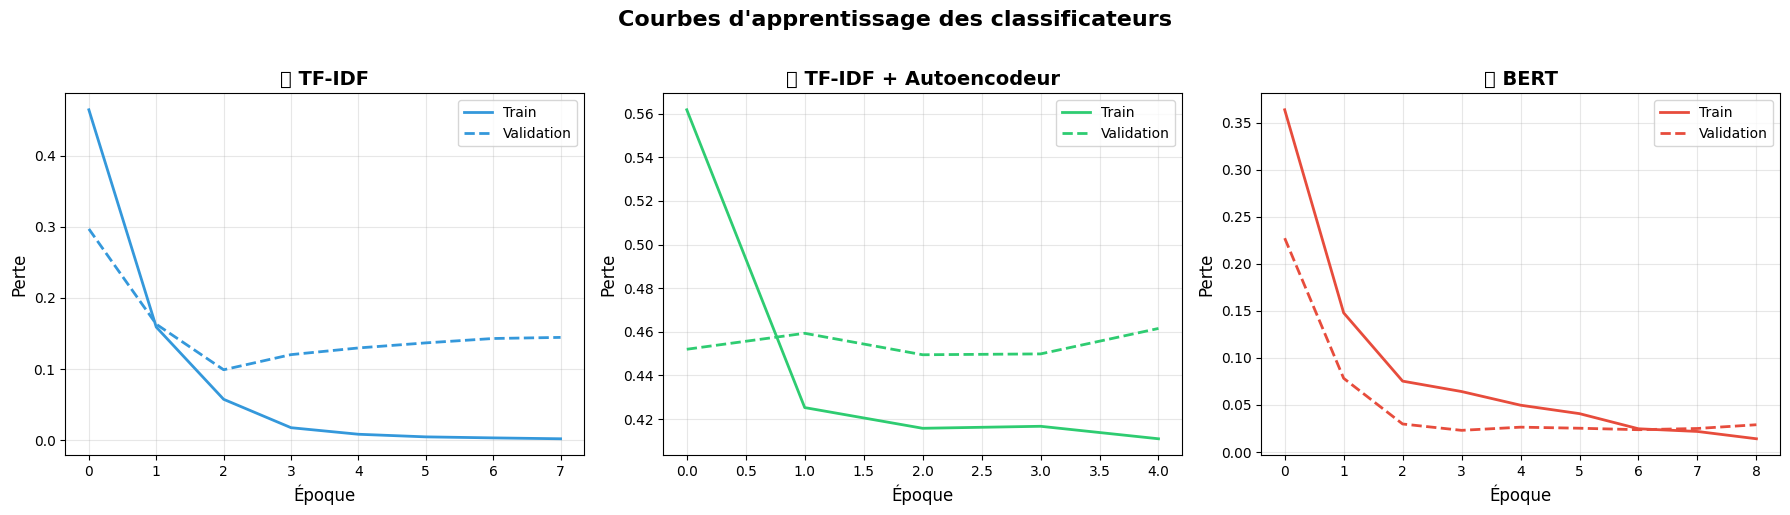

In [40]:
# ============================================================
# 21. VISUALISATION DES COURBES D'APPRENTISSAGE
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_info = [
    ('TF-IDF', history_tfidf, '#3498db'),
    ('TF-IDF + Autoencodeur', history_ae_clf, '#2ecc71'),
    ('BERT', history_bert, '#e74c3c')
]

for ax, (name, history, color) in zip(axes, models_info):
    ax.plot(history.history['loss'], label='Train', color=color, linewidth=2)
    ax.plot(history.history['val_loss'], label='Validation', color=color, linewidth=2, linestyle='--')
    ax.set_title(f'📉 {name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Époque', fontsize=12)
    ax.set_ylabel('Perte', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Courbes d\'apprentissage des classificateurs', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

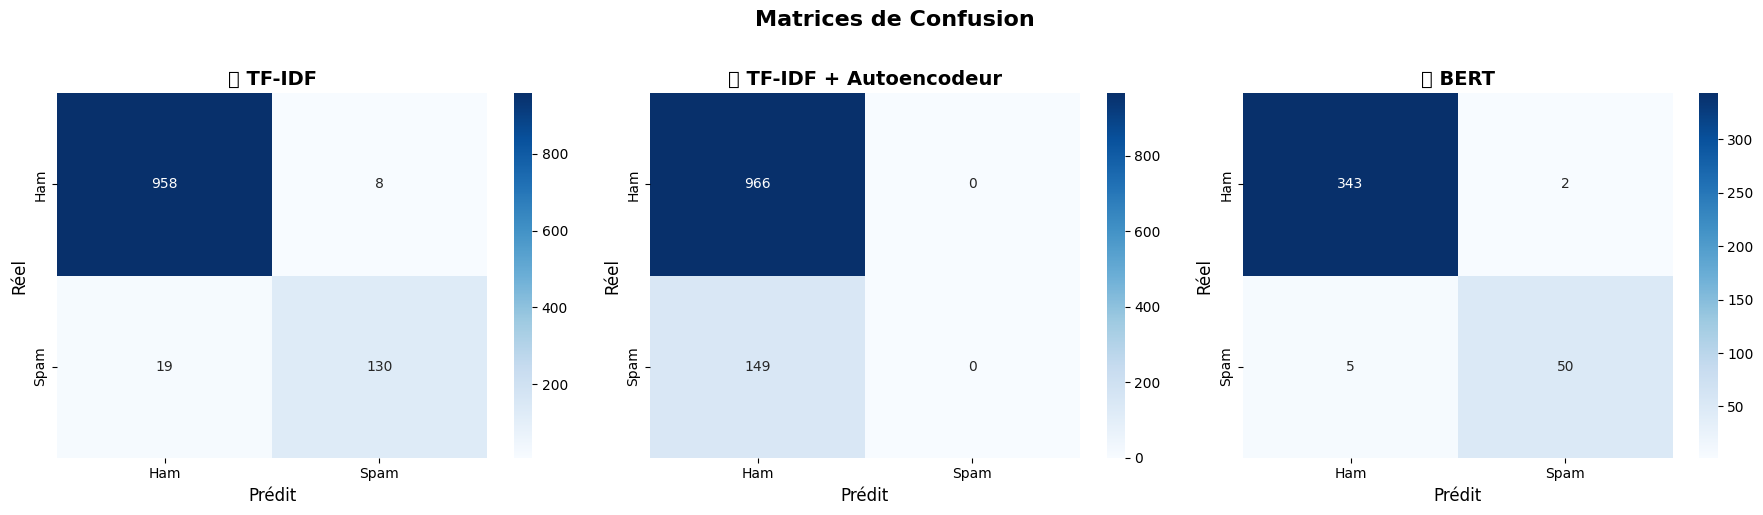

In [41]:
# ============================================================
# 22. MATRICES DE CONFUSION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    ('TF-IDF', y_test, y_pred_tfidf),
    ('TF-IDF + Autoencodeur', y_test, y_pred_ae),
    ('BERT', y_test_bert, y_pred_bert)
]

for ax, (name, y_true, y_pred) in zip(axes, predictions):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    ax.set_title(f'📊 {name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Prédit', fontsize=12)
    ax.set_ylabel('Réel', fontsize=12)

plt.suptitle('Matrices de Confusion', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


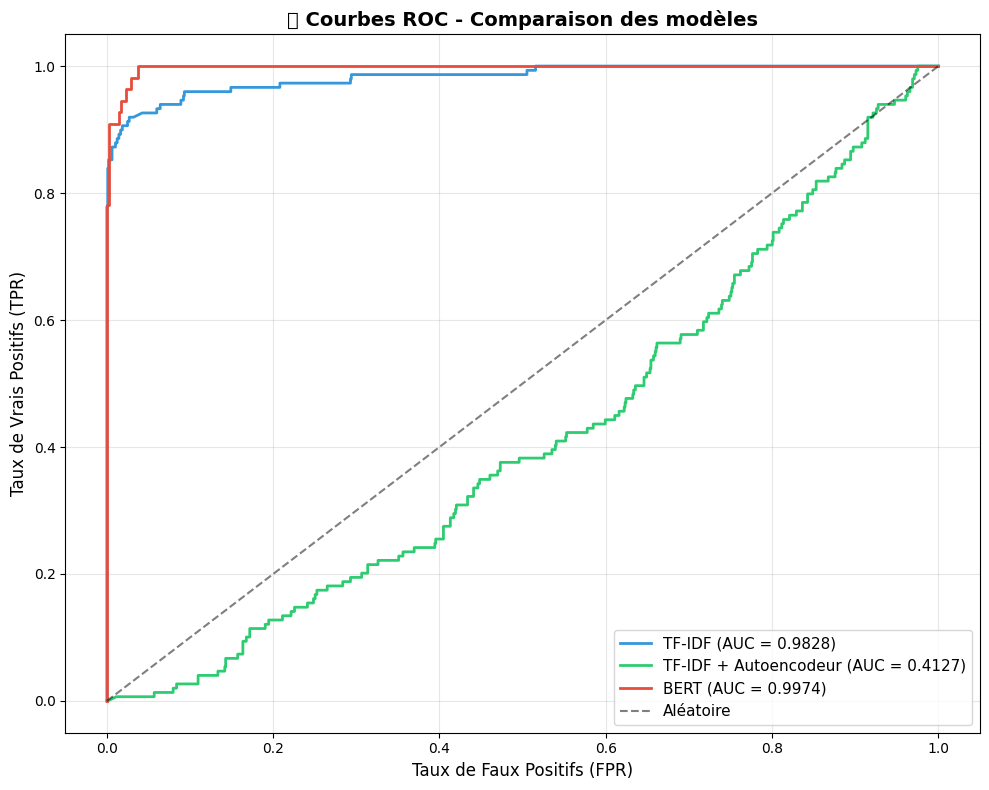

In [42]:
# ============================================================
# 23. COURBES ROC
# ============================================================

plt.figure(figsize=(10, 8))

# Calculer les courbes ROC
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, classifier_tfidf.predict(X_test))
fpr_ae, tpr_ae, _ = roc_curve(y_test, classifier_ae.predict(X_test_encoded))
fpr_bert, tpr_bert, _ = roc_curve(y_test_bert, classifier_bert.predict(X_test_bert))

# Tracer les courbes
plt.plot(fpr_tfidf, tpr_tfidf, label=f'TF-IDF (AUC = {auc_tfidf:.4f})', color='#3498db', linewidth=2)
plt.plot(fpr_ae, tpr_ae, label=f'TF-IDF + Autoencodeur (AUC = {auc_ae:.4f})', color='#2ecc71', linewidth=2)
plt.plot(fpr_bert, tpr_bert, label=f'BERT (AUC = {auc_bert:.4f})', color='#e74c3c', linewidth=2)

# Ligne de référence (classificateur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire', alpha=0.5)

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('📈 Courbes ROC - Comparaison des modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# ============================================================
# 24. RAPPORTS DE CLASSIFICATION DÉTAILLÉS
# ============================================================

print("=" * 70)
print("📋 RAPPORTS DE CLASSIFICATION DÉTAILLÉS")
print("=" * 70)

print("\n🔹 1. TF-IDF (5000 dimensions)")
print("-" * 50)
print(classification_report(y_test, y_pred_tfidf, target_names=['Ham', 'Spam']))

print("\n🔹 2. TF-IDF + Autoencodeur (64 dimensions)")
print("-" * 50)
print(classification_report(y_test, y_pred_ae, target_names=['Ham', 'Spam']))

print("\n🔹 3. BERT (768 dimensions)")
print("-" * 50)
print(classification_report(y_test_bert, y_pred_bert, target_names=['Ham', 'Spam']))

📋 RAPPORTS DE CLASSIFICATION DÉTAILLÉS

🔹 1. TF-IDF (5000 dimensions)
--------------------------------------------------
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       966
        Spam       0.94      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.96      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


🔹 2. TF-IDF + Autoencodeur (64 dimensions)
--------------------------------------------------
              precision    recall  f1-score   support

         Ham       0.87      1.00      0.93       966
        Spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115


🔹 3. BERT (768 dimensions)
--------------------------------------------------
              precision    recall  f1-score   suppo

### 📝 Analyse Finale des Résultats - Comparaison des 3 Approches

---

## 🏆 Tableau Comparatif des Performances

| Modèle | Dimensions | Accuracy | AUC-ROC | Recall Spam | Précision Spam |
|--------|------------|----------|---------|-------------|----------------|
| **TF-IDF** | 5000 | **97.58%** | 0.9828 | 87% | 94% |
| **TF-IDF + Autoencodeur** | 64 | 86.64% | 0.4127 | **0%** ⚠️ | 0% |
| **BERT** | 768 | **98.25%** | **0.9974** | 91% | 96% |

---

## 🔍 Analyse Détaillée par Modèle

### 1️⃣ TF-IDF (5000 dimensions) - ✅ Bon
- **Accuracy** : 97.58% - Très bon résultat
- **Recall Spam** : 87% - Détecte 87% des spams
- **AUC-ROC** : 0.9828 - Excellente discrimination
- **Avantage** : Simple, rapide, interprétable
- **Inconvénient** : Haute dimensionnalité (5000 features)

### 2️⃣ TF-IDF + Autoencodeur (64 dimensions) - ❌ Problématique
- **Accuracy** : 86.64% - Semble correct MAIS...
- **Recall Spam** : **0%** - NE DÉTECTE AUCUN SPAM! 🚨
- **AUC-ROC** : 0.4127 - Pire qu'aléatoire (<0.5)

#### ⚠️ Diagnostic du problème :
Le modèle prédit **TOUT comme Ham** car :
1. L'autoencodeur a **perdu l'information discriminante** lors de la compression
2. Le dataset est **déséquilibré** (86.6% ham) → prédire "ham" donne 86.6% d'accuracy
3. L'autoencodeur non-supervisé **ne sait pas** quelles features sont importantes

### 3️⃣ BERT (768 dimensions) - ✅ Meilleur
- **Accuracy** : 98.25% - Meilleur score
- **Recall Spam** : 91% - Détecte 91% des spams
- **AUC-ROC** : 0.9974 - Quasi-parfait
- **Avantage** : Compréhension sémantique profonde
- **Inconvénient** : Temps de calcul plus long

---

## 📊 Interprétation des Métriques

### Pourquoi l'Accuracy peut être trompeuse :
- Avec 86.6% de ham, un modèle qui prédit **toujours ham** obtient 86.6% d'accuracy
- C'est exactement ce qui se passe avec l'autoencodeur!
- **Le Recall et l'AUC-ROC** sont plus fiables pour les datasets déséquilibrés

### Importance du Recall pour la détection de spam :
- **Recall = TP / (TP + FN)** = Proportion de vrais spams détectés
- Un **faux négatif** (spam non détecté) peut être dangereux pour l'utilisateur
- BERT avec 91% de recall est le plus sûr

---

## 🎯 Conclusion et Recommandations

### Classement final :
1. 🥇 **BERT** - Meilleur équilibre performance/robustesse
2. 🥈 **TF-IDF** - Bon compromis simplicité/performance
3. 🥉 **Autoencodeur** - Non recommandé (ne détecte pas les spams)

### Leçons apprises :
1. **La réduction de dimensionnalité non-supervisée** peut perdre des informations critiques
2. **L'accuracy seule** n'est pas suffisante pour évaluer un modèle
3. **Les modèles pré-entraînés** (BERT) capturent mieux la sémantique
4. **La stratification** est essentielle pour les datasets déséquilibrés

---

## 9️⃣ Test sur de Nouveaux Messages

In [44]:
# ============================================================
# 25. FONCTION DE PRÉDICTION POUR NOUVEAUX MESSAGES
# ============================================================

def predict_spam(message, method='bert'):
    """
    Prédit si un message est spam ou ham.
    
    Args:
        message: Le message à analyser
        method: 'tfidf', 'autoencoder', ou 'bert'
        
    Returns:
        Tuple (label, probabilité)
    """
    if method == 'tfidf':
        # Prétraitement + TF-IDF
        clean_msg = preprocess_text(message)
        msg_tfidf = tfidf_vectorizer.transform([clean_msg]).toarray()
        prob = classifier_tfidf.predict(msg_tfidf)[0][0]
        
    elif method == 'autoencoder':
        # Prétraitement + TF-IDF + Autoencodeur
        clean_msg = preprocess_text(message)
        msg_tfidf = tfidf_vectorizer.transform([clean_msg]).toarray()
        msg_encoded = encoder.predict(msg_tfidf, verbose=0)
        prob = classifier_ae.predict(msg_encoded, verbose=0)[0][0]
        
    elif method == 'bert':
        # BERT
        msg_bert = get_bert_embeddings([message], tokenizer_bert, model_bert, device)
        prob = classifier_bert.predict(msg_bert, verbose=0)[0][0]
    
    label = "🚨 SPAM" if prob > 0.5 else "✅ HAM (Légitime)"
    return label, prob

# Messages de test
test_messages = [
    "Hey! How are you doing? Want to grab lunch tomorrow?",
    "CONGRATULATIONS! You've won £10000! Call NOW to claim your prize: 0800-123-456",
    "Meeting at 3pm today. Don't forget the report.",
    "FREE entry to win a brand new iPhone! Text WIN to 84521",
    "Can you pick up some milk on your way home?",
    "URGENT: Your bank account has been compromised. Click here immediately!"
]

print("=" * 70)
print("🔮 PRÉDICTIONS SUR DE NOUVEAUX MESSAGES")
print("=" * 70)

for msg in test_messages:
    label_bert, prob_bert = predict_spam(msg, method='bert')
    print(f"\n📩 Message: \"{msg[:60]}...\"" if len(msg) > 60 else f"\n📩 Message: \"{msg}\"")
    print(f"   → Prédiction BERT: {label_bert} (probabilité: {prob_bert:.2%})")

🔮 PRÉDICTIONS SUR DE NOUVEAUX MESSAGES

📩 Message: "Hey! How are you doing? Want to grab lunch tomorrow?"
   → Prédiction BERT: ✅ HAM (Légitime) (probabilité: 0.01%)

📩 Message: "CONGRATULATIONS! You've won £10000! Call NOW to claim your p..."
   → Prédiction BERT: 🚨 SPAM (probabilité: 97.28%)

📩 Message: "Meeting at 3pm today. Don't forget the report."
   → Prédiction BERT: ✅ HAM (Légitime) (probabilité: 0.46%)

📩 Message: "FREE entry to win a brand new iPhone! Text WIN to 84521"
   → Prédiction BERT: 🚨 SPAM (probabilité: 95.52%)

📩 Message: "Can you pick up some milk on your way home?"
   → Prédiction BERT: ✅ HAM (Légitime) (probabilité: 0.02%)

📩 Message: "URGENT: Your bank account has been compromised. Click here i..."
   → Prédiction BERT: 🚨 SPAM (probabilité: 95.86%)


## 🔟 Conclusion et Analyse

### 📊 Résumé des approches utilisées

| Étape | Technique | Description |
|-------|-----------|-------------|
| **Prétraitement** | NLTK | Tokenisation, stopwords, lemmatisation |
| **Vectorisation** | TF-IDF | Transformation texte → vecteurs (5000 dim) |
| **Réduction dim.** | Autoencodeur | Compression 5000 → 64 dimensions |
| **Features BERT** | Transformers | Embeddings contextuels (768 dim) |
| **Classification** | Réseau Dense | Classification binaire spam/ham |

### 🎯 Points clés

1. **Prétraitement textuel** (Cours 10) :
   - La normalisation et le nettoyage sont essentiels
   - La suppression des stopwords réduit le bruit
   - La lemmatisation regroupe les formes d'un même mot

2. **Autoencodeur** (Cours 9) :
   - Réduction de dimensionnalité non-linéaire
   - Préserve l'information essentielle
   - Réduit le risque de surapprentissage

3. **BERT** (Cours 11) :
   - Capture le contexte bidirectionnel
   - Embeddings pré-entraînés très riches
   - Excellent pour le transfer learning

### 🚀 Améliorations possibles
- Fine-tuning de BERT sur le dataset
- Équilibrage des classes (SMOTE, class weights)
- Ensemble de modèles
- Hyperparameter tuning

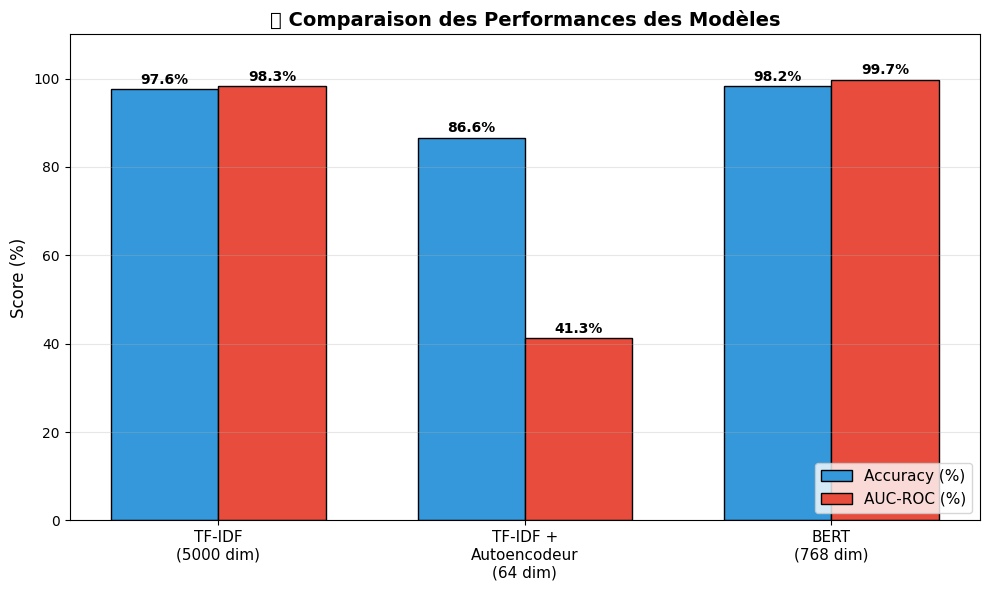


✅ PROJET TERMINÉ - Évaluation Sommative UA3

📚 Concepts couverts:
   ✓ Prétraitement textuel (Cours 10)
   ✓ Vectorisation TF-IDF
   ✓ Autoencodeurs pour réduction de dimensionnalité (Cours 9)
   ✓ Extraction de caractéristiques avec BERT (Cours 11)
   ✓ Classification binaire avec réseaux de neurones


In [45]:
# ============================================================
# 26. VISUALISATION COMPARATIVE FINALE
# ============================================================

# Créer un graphique de comparaison des performances
fig, ax = plt.subplots(figsize=(10, 6))

models = ['TF-IDF\n(5000 dim)', 'TF-IDF +\nAutoencodeur\n(64 dim)', 'BERT\n(768 dim)']
accuracies = [acc_tfidf * 100, acc_ae * 100, acc_bert * 100]
aucs = [auc_tfidf, auc_ae, auc_bert]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy (%)', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, [a * 100 for a in aucs], width, label='AUC-ROC (%)', color='#e74c3c', edgecolor='black')

# Ajouter les valeurs sur les barres
for bar, val in zip(bars1, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, val in zip(bars2, [a * 100 for a in aucs]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('🏆 Comparaison des Performances des Modèles', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✅ PROJET TERMINÉ - Évaluation Sommative UA3")
print("=" * 70)
print("\n📚 Concepts couverts:")
print("   ✓ Prétraitement textuel (Cours 10)")
print("   ✓ Vectorisation TF-IDF")
print("   ✓ Autoencodeurs pour réduction de dimensionnalité (Cours 9)")
print("   ✓ Extraction de caractéristiques avec BERT (Cours 11)")
print("   ✓ Classification binaire avec réseaux de neurones")

"Voici le contexte : j'ai un projet de classification SMS spam avec TF-IDF, Autoencodeur et BERT. Le notebook est 000Projet_evaluation_UA3.ipynb"

